In [14]:
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt

# Familiarize Yourself with the Datasets


In [15]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('files/Software_5.json.gz')
len(df)

12805

Clean dataset from missing ratings and duplicates (cases where the same user has rated the same item multiple times) if any

In [16]:
df = df.dropna(subset=["overall"])
print(len(df))
df = df.sort_values("unixReviewTime").drop_duplicates(subset=["reviewerID", "asin"], keep="last")
print(len(df))

12805
11884


Create a test set by extracting the latest (in time) positively rated item (rating $\geq 4$) by each user

In [17]:
test = df[df["overall"] >= 4].sort_values("unixReviewTime").drop_duplicates(subset=["reviewerID"], keep="last")
train = df.drop(labels=test.index)
len(test)

1713

Remove users that do not appear in the training set

In [18]:
test = test.loc[test["reviewerID"].isin(train["reviewerID"])]
len(train), len(test)

(10171, 1711)

Save data split

In [19]:
train.to_pickle("files/train.pkl")
test.to_pickle("files/test.pkl")

## User and item statistics

In [20]:
import plotly.express as px
## Counts of ratings per item, sorted by frequency

df = train.groupby(by="asin").size().sort_values(ascending=False)
fig = px.histogram(y=df, x=np.arange(len(df)), nbins=len(df), color_discrete_sequence=['royalblue']) 

fig.update_layout(
    width=600,
    height=400,
    yaxis_title="Count",
    xaxis_title="Sorted item list",
#     legend_title="Legend Title",
)
fig.update_traces(opacity=0.85)

fig.show()
fig.write_image("images/asin_hist.pdf")


In [21]:
## mean rating by user and item in train set 
df = train.groupby(by=["reviewerID"])["overall"].mean()
df = pd.DataFrame(df).reset_index(drop=True)
df["type"] = "mean by reviewer"
df2 = train.groupby(by=["asin"])["overall"].mean()
df2 = pd.DataFrame(df2).reset_index(drop=True)
df2["type"] = "mean by item"
df3 = pd.concat([df, df2])

fig = px.violin(df3, y="overall", x="type", box=True, template="plotly")
fig.data[0].update(span = [0.9,5.1], spanmode='manual')

fig.update_layout(
    width=600,
    height=400,
    yaxis_title="Mean rating",
    xaxis_title="",
#     legend_title="Legend Title",
)
fig.update_traces(line_color='black', fillcolor='royalblue', opacity=0.65, marker=dict(
        color="black"))
#         outliercolor='rgba(219, 64, 82, 0.6)'))

fig.show()
fig.write_image("images/meanrating_viol.pdf")

## Further statistics (not included in report)

count    1824.000000
mean        5.576206
std         3.488828
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        51.000000
dtype: float64

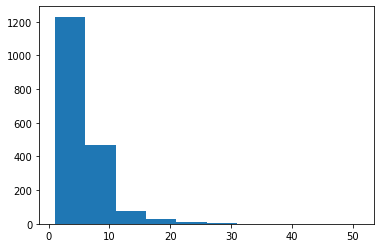

In [22]:
# number of ratings per user
sizes = train.groupby(by="reviewerID").size()
plt.hist(sizes); sizes.describe()

12.71375

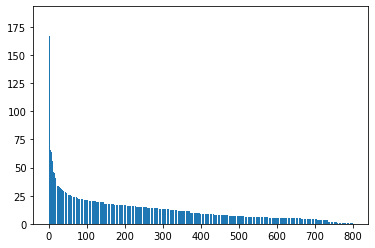

In [23]:
# number of ratings per item in train set
sizes = train.groupby(by="asin").size()
plt.bar(np.arange(len(sizes)), np.sort(sizes)[::-1]); sizes.mean()

3.557172557172557

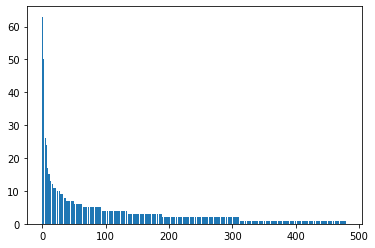

In [24]:
# number of ratings per item in test set
sizes = test.groupby(by="asin").size()
plt.bar(np.arange(len(sizes)), np.sort(sizes)[::-1]); sizes.mean()

count    1824.00000
mean        3.82036
std         1.11164
min         1.00000
25%         3.25000
50%         4.00000
75%         4.80000
max         5.00000
Name: overall, dtype: float64

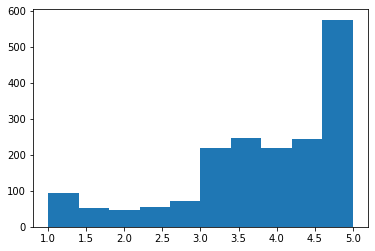

In [25]:
# mean rating per user in train set 
ratings = train.groupby(by=["reviewerID"])["overall"].mean()
plt.hist(ratings)
ratings.describe()

count    800.000000
mean       3.584263
std        0.842344
min        1.000000
25%        3.064683
50%        3.722222
75%        4.169118
max        5.000000
Name: overall, dtype: float64

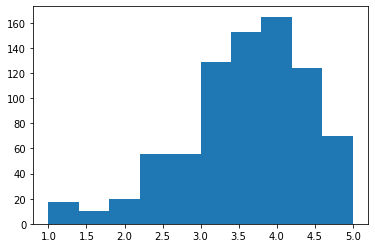

In [26]:
# mean rating per item in train set 
ratings = train.groupby(by=["asin"])["overall"].mean()
plt.hist(ratings); ratings.describe()